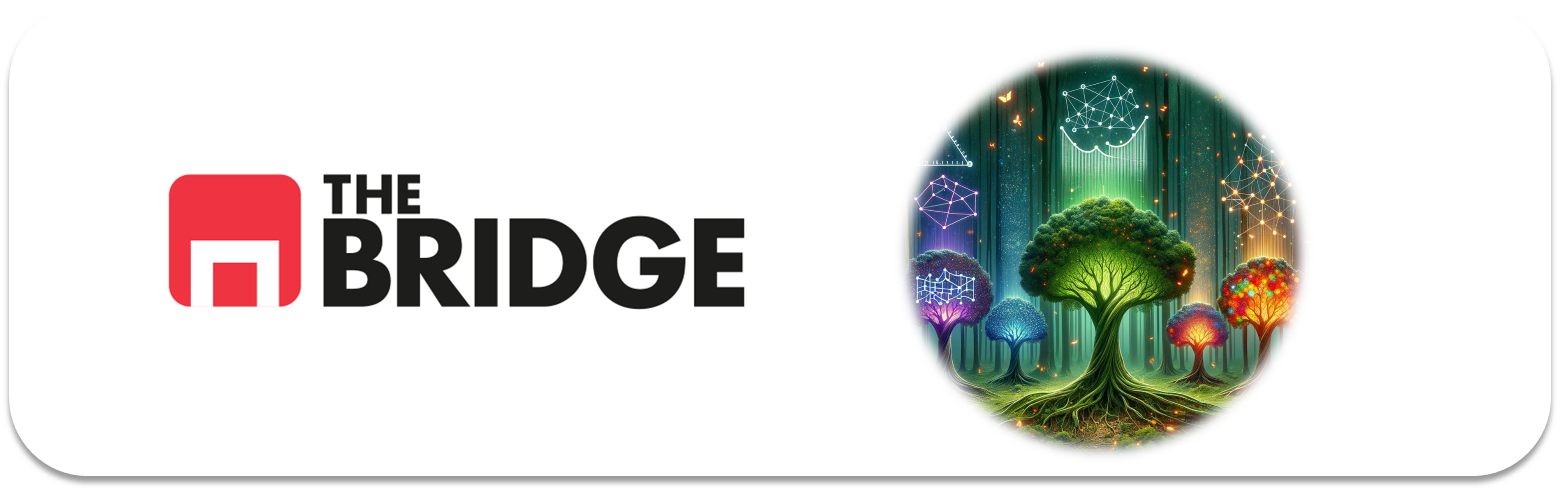

## PRACTICA OBLIGATORIA: **Ensembles: Bagging y Boosting**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

# Modelos de Bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos de Boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menoss tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

In [3]:
# CARGA Y EXPLORACIÓN DE DATOS
# =============================

# URL y nombres de columnas
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

# Cargar dataset
df = pd.read_csv(url, names=names)

print("=" * 80)
print("EXPLORACIÓN INICIAL DEL DATASET")
print("=" * 80)
print(f"\nDimensiones del dataset: {df.shape}")
print(f"\nPrimeras filas:\n{df.head()}")
print(f"\nInformación del dataset:")
print(df.info())
print(f"\nEstadísticas descriptivas:\n{df.describe()}")
print(f"\nValores nulos:\n{df.isnull().sum()}")
print(f"\nDistribución de la variable objetivo:\n{df['class'].value_counts()}")
print(f"\nProporción de clases:\n{df['class'].value_counts(normalize=True)}")

EXPLORACIÓN INICIAL DEL DATASET

Dimensiones del dataset: (768, 9)

Primeras filas:
   preg  plas  pres  skin  test  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory u

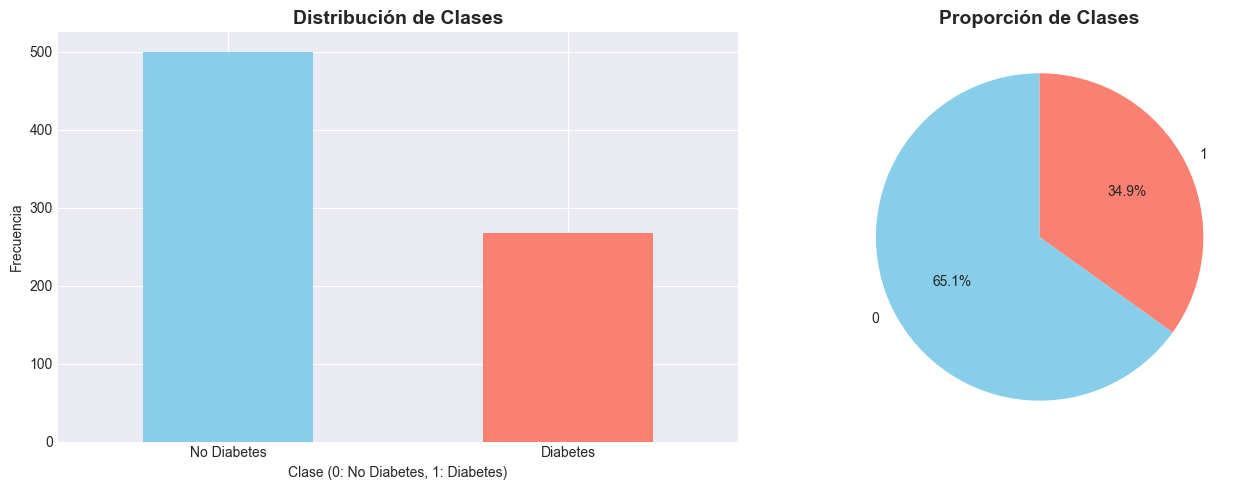

In [4]:
# ANÁLISIS EXPLORATORIO
# =====================

# Visualización de la distribución de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['class'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase (0: No Diabetes, 1: Diabetes)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(['No Diabetes', 'Diabetes'], rotation=0)

df['class'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], 
                                               autopct='%1.1f%%', 
                                               colors=['skyblue', 'salmon'],
                                               startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

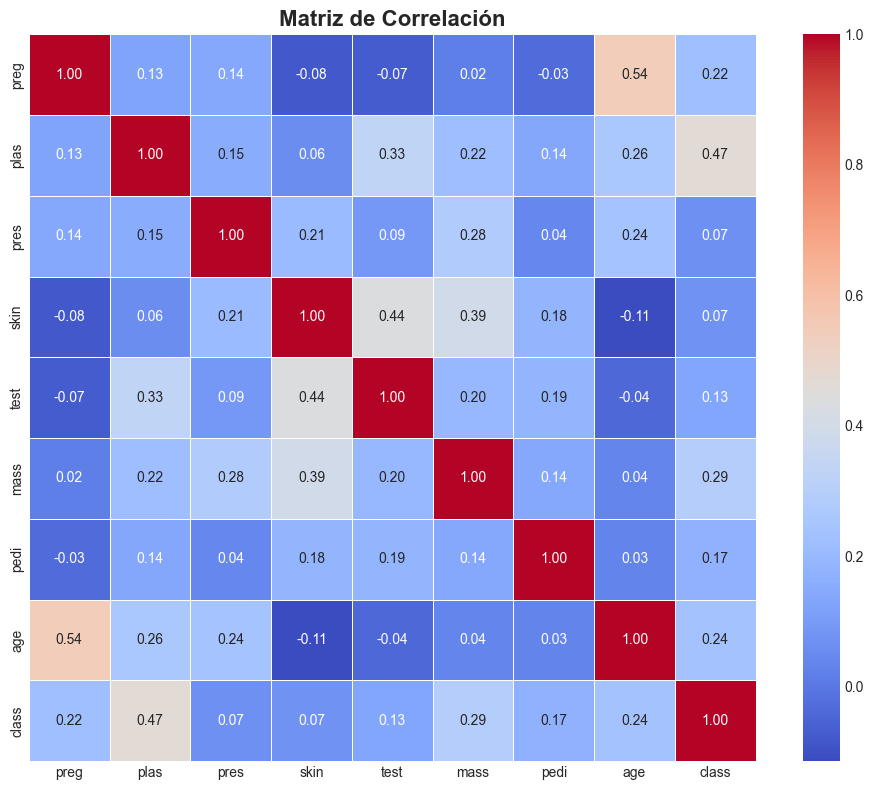


Correlación con la variable objetivo:
class    1.000000
plas     0.466581
mass     0.292695
age      0.238356
preg     0.221898
pedi     0.173844
test     0.130548
skin     0.074752
pres     0.065068
Name: class, dtype: float64


In [5]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelación con la variable objetivo:")
print(correlation_matrix['class'].sort_values(ascending=False))

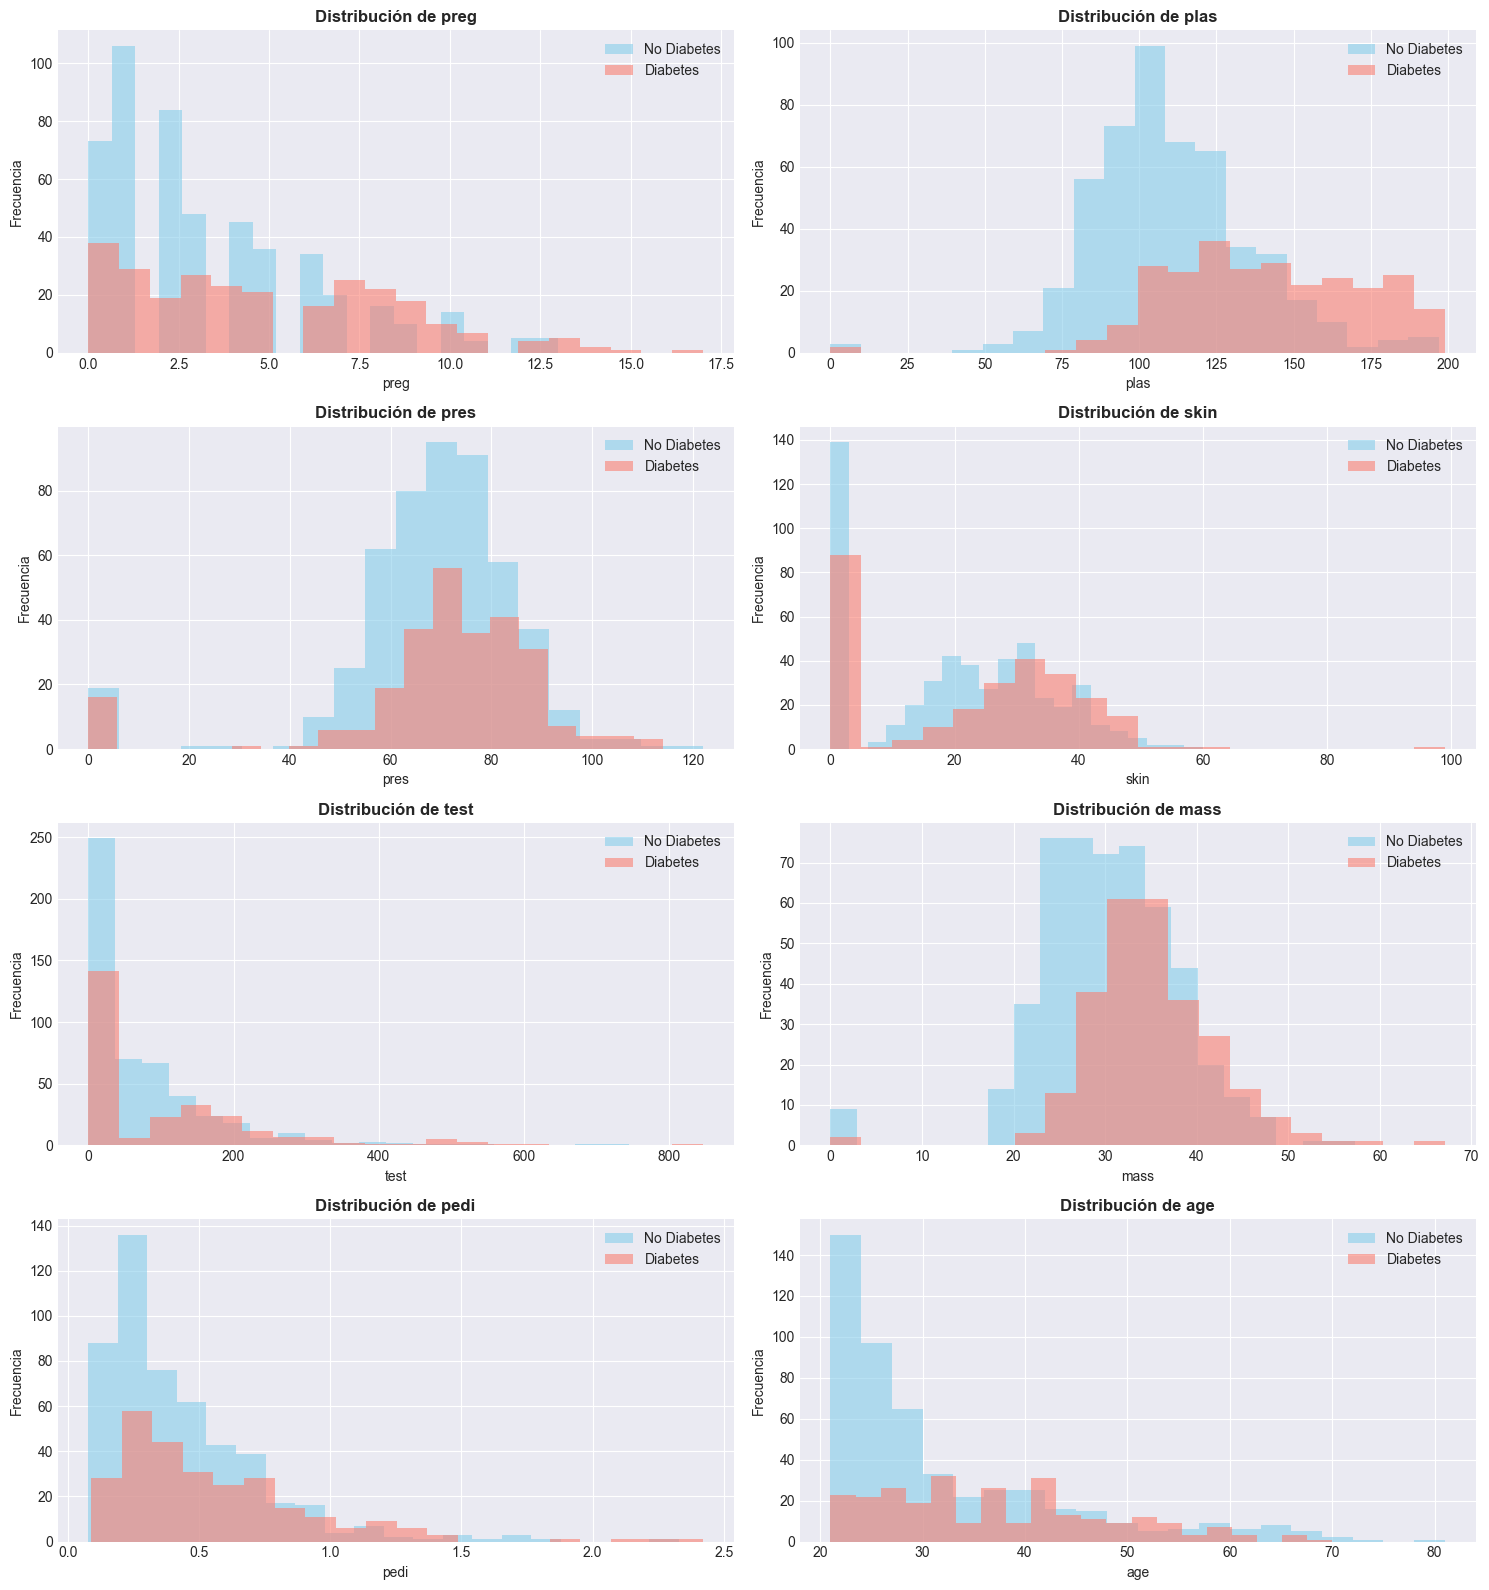

In [6]:
# Distribución de características
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
axes = axes.ravel()

for idx, col in enumerate(df.columns[:-1]):
    axes[idx].hist(df[df['class']==0][col], bins=20, alpha=0.6, label='No Diabetes', color='skyblue')
    axes[idx].hist(df[df['class']==1][col], bins=20, alpha=0.6, label='Diabetes', color='salmon')
    axes[idx].set_title(f'Distribución de {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [7]:
# DETECCIÓN DE VALORES ANÓMALOS (CEROS)
# ======================================

# Algunas variables no pueden tener valor 0 (son biológicamente imposibles)
columns_with_zeros = ['plas', 'pres', 'skin', 'test', 'mass']

print("\n" + "=" * 80)
print("DETECCIÓN DE VALORES CERO (VALORES ANÓMALOS)")
print("=" * 80)

for col in columns_with_zeros:
    zero_count = (df[col] == 0).sum()
    zero_percentage = (zero_count / len(df)) * 100
    print(f"{col}: {zero_count} valores cero ({zero_percentage:.2f}%)")

# Reemplazar ceros por NaN en estas columnas
df_cleaned = df.copy()
df_cleaned[columns_with_zeros] = df_cleaned[columns_with_zeros].replace(0, np.nan)

# Imputar valores faltantes con la mediana
print("\nImputando valores faltantes con la mediana...")
for col in columns_with_zeros:
    median_value = df_cleaned[col].median()
    df_cleaned[col].fillna(median_value, inplace=True)

print("Imputación completada.")


DETECCIÓN DE VALORES CERO (VALORES ANÓMALOS)
plas: 5 valores cero (0.65%)
pres: 35 valores cero (4.56%)
skin: 227 valores cero (29.56%)
test: 374 valores cero (48.70%)
mass: 11 valores cero (1.43%)

Imputando valores faltantes con la mediana...
Imputación completada.


In [8]:
# PREPARACIÓN DE DATOS
# ====================

# Separar características y objetivo
X = df_cleaned.drop('class', axis=1)
y = df_cleaned['class']

# División en train y test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "=" * 80)
print("DIVISIÓN DE DATOS")
print("=" * 80)
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de test: {X_test.shape}")
print(f"\nDistribución en entrenamiento:\n{y_train.value_counts()}")
print(f"\nDistribución en test:\n{y_test.value_counts()}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


DIVISIÓN DE DATOS
Conjunto de entrenamiento: (614, 8)
Conjunto de test: (154, 8)

Distribución en entrenamiento:
class
0    400
1    214
Name: count, dtype: int64

Distribución en test:
class
0    100
1     54
Name: count, dtype: int64


In [9]:
# FUNCIÓN PARA EVALUAR MODELOS
# =============================

def evaluate_model(model, X_train, y_train, model_name, cv=5):
    """
    Evalúa un modelo usando validación cruzada
    """
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    cv_scores_roc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    
    results = {
        'Model': model_name,
        'CV Accuracy Mean': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std(),
        'CV F1 Mean': cv_scores_f1.mean(),
        'CV F1 Std': cv_scores_f1.std(),
        'CV ROC-AUC Mean': cv_scores_roc.mean(),
        'CV ROC-AUC Std': cv_scores_roc.std()
    }
    
    return results

In [10]:
# MODELOS DE BAGGING
# ==================

print("\n" + "=" * 80)
print("ENTRENAMIENTO DE MODELOS DE BAGGING")
print("=" * 80)

results_list = []

# 1. BAGGING CLASSIFIER CON ÁRBOLES DE DECISIÓN
print("\n1. Bagging Classifier con Árboles de Decisión")
print("-" * 80)
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

bagging_results = evaluate_model(bagging_model, X_train_scaled, y_train, 
                                 'Bagging Classifier')
results_list.append(bagging_results)
print(f"Accuracy CV: {bagging_results['CV Accuracy Mean']:.4f} (+/- {bagging_results['CV Accuracy Std']:.4f})")
print(f"F1-Score CV: {bagging_results['CV F1 Mean']:.4f} (+/- {bagging_results['CV F1 Std']:.4f})")
print(f"ROC-AUC CV: {bagging_results['CV ROC-AUC Mean']:.4f} (+/- {bagging_results['CV ROC-AUC Std']:.4f})")

# 2. RANDOM FOREST
print("\n2. Random Forest Classifier")
print("-" * 80)
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_results = evaluate_model(rf_model, X_train_scaled, y_train, 
                            'Random Forest')
results_list.append(rf_results)
print(f"Accuracy CV: {rf_results['CV Accuracy Mean']:.4f} (+/- {rf_results['CV Accuracy Std']:.4f})")
print(f"F1-Score CV: {rf_results['CV F1 Mean']:.4f} (+/- {rf_results['CV F1 Std']:.4f})")
print(f"ROC-AUC CV: {rf_results['CV ROC-AUC Mean']:.4f} (+/- {rf_results['CV ROC-AUC Std']:.4f})")


ENTRENAMIENTO DE MODELOS DE BAGGING

1. Bagging Classifier con Árboles de Decisión
--------------------------------------------------------------------------------
Accuracy CV: 0.7395 (+/- 0.0218)
F1-Score CV: 0.5945 (+/- 0.0523)
ROC-AUC CV: 0.8103 (+/- 0.0179)

2. Random Forest Classifier
--------------------------------------------------------------------------------
Accuracy CV: 0.7688 (+/- 0.0337)
F1-Score CV: 0.6381 (+/- 0.0470)
ROC-AUC CV: 0.8248 (+/- 0.0226)


In [11]:
# MODELOS DE BOOSTING
# ===================

print("\n" + "=" * 80)
print("ENTRENAMIENTO DE MODELOS DE BOOSTING")
print("=" * 80)

# 3. ADABOOST
print("\n3. AdaBoost Classifier")
print("-" * 80)
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    random_state=42
)

adaboost_results = evaluate_model(adaboost_model, X_train_scaled, y_train, 
                                  'AdaBoost')
results_list.append(adaboost_results)
print(f"Accuracy CV: {adaboost_results['CV Accuracy Mean']:.4f} (+/- {adaboost_results['CV Accuracy Std']:.4f})")
print(f"F1-Score CV: {adaboost_results['CV F1 Mean']:.4f} (+/- {adaboost_results['CV F1 Std']:.4f})")
print(f"ROC-AUC CV: {adaboost_results['CV ROC-AUC Mean']:.4f} (+/- {adaboost_results['CV ROC-AUC Std']:.4f})")

# 4. GRADIENT BOOSTING
print("\n4. Gradient Boosting Classifier")
print("-" * 80)
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)

gb_results = evaluate_model(gb_model, X_train_scaled, y_train, 
                            'Gradient Boosting')
results_list.append(gb_results)
print(f"Accuracy CV: {gb_results['CV Accuracy Mean']:.4f} (+/- {gb_results['CV Accuracy Std']:.4f})")
print(f"F1-Score CV: {gb_results['CV F1 Mean']:.4f} (+/- {gb_results['CV F1 Std']:.4f})")
print(f"ROC-AUC CV: {gb_results['CV ROC-AUC Mean']:.4f} (+/- {gb_results['CV ROC-AUC Std']:.4f})")

# 5. XGBOOST
print("\n5. XGBoost Classifier")
print("-" * 80)
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)

xgb_results = evaluate_model(xgb_model, X_train_scaled, y_train, 
                             'XGBoost')
results_list.append(xgb_results)
print(f"Accuracy CV: {xgb_results['CV Accuracy Mean']:.4f} (+/- {xgb_results['CV Accuracy Std']:.4f})")
print(f"F1-Score CV: {xgb_results['CV F1 Mean']:.4f} (+/- {xgb_results['CV F1 Std']:.4f})")
print(f"ROC-AUC CV: {xgb_results['CV ROC-AUC Mean']:.4f} (+/- {xgb_results['CV ROC-AUC Std']:.4f})")


ENTRENAMIENTO DE MODELOS DE BOOSTING

3. AdaBoost Classifier
--------------------------------------------------------------------------------
Accuracy CV: 0.7492 (+/- 0.0126)
F1-Score CV: 0.6036 (+/- 0.0332)
ROC-AUC CV: 0.8292 (+/- 0.0160)

4. Gradient Boosting Classifier
--------------------------------------------------------------------------------
Accuracy CV: 0.7622 (+/- 0.0313)
F1-Score CV: 0.6424 (+/- 0.0516)
ROC-AUC CV: 0.8146 (+/- 0.0273)

5. XGBoost Classifier
--------------------------------------------------------------------------------
Accuracy CV: 0.7346 (+/- 0.0319)
F1-Score CV: 0.6126 (+/- 0.0458)
ROC-AUC CV: 0.7832 (+/- 0.0303)



COMPARACIÓN DE MODELOS

              Model  CV Accuracy Mean  CV Accuracy Std  CV F1 Mean  CV F1 Std  CV ROC-AUC Mean  CV ROC-AUC Std
Bagging Classifier          0.739478         0.021763    0.594515   0.052299         0.810324        0.017908
     Random Forest          0.768772         0.033686    0.638076   0.047010         0.824772        0.022634
          AdaBoost          0.749207         0.012590    0.603569   0.033206         0.829230        0.016001
 Gradient Boosting          0.762228         0.031339    0.642368   0.051611         0.814582        0.027305
           XGBoost          0.734599         0.031855    0.612614   0.045782         0.783153        0.030266


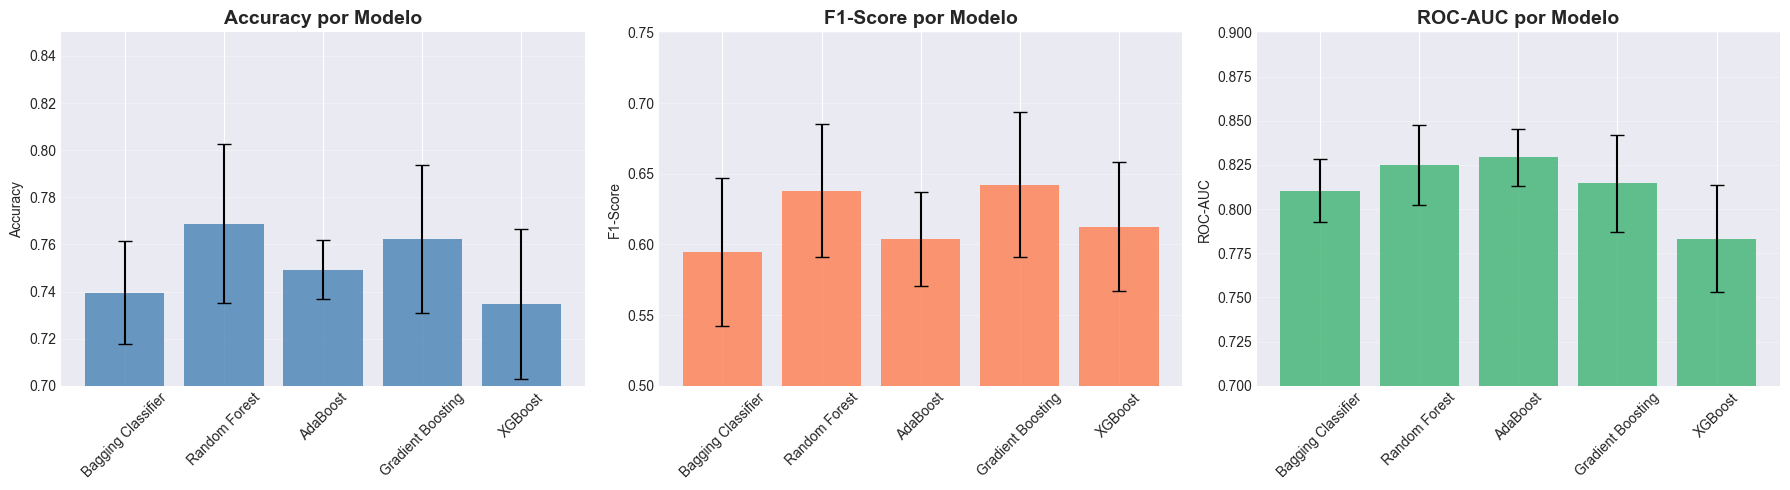


MEJOR MODELO SELECCIONADO: AdaBoost

Justificación: Se selecciona basándose en ROC-AUC, ya que es una métrica
robusta para problemas de clasificación desbalanceados como este.


In [12]:
# COMPARACIÓN DE MODELOS
# ======================

print("\n" + "=" * 80)
print("COMPARACIÓN DE MODELOS")
print("=" * 80)

results_df = pd.DataFrame(results_list)
print("\n", results_df.to_string(index=False))

# Visualización de resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(results_df['Model'], results_df['CV Accuracy Mean'], 
            yerr=results_df['CV Accuracy Std'], capsize=5, color='steelblue', alpha=0.8)
axes[0].set_title('Accuracy por Modelo', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0.7, 0.85])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# F1-Score
axes[1].bar(results_df['Model'], results_df['CV F1 Mean'], 
            yerr=results_df['CV F1 Std'], capsize=5, color='coral', alpha=0.8)
axes[1].set_title('F1-Score por Modelo', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim([0.5, 0.75])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# ROC-AUC
axes[2].bar(results_df['Model'], results_df['CV ROC-AUC Mean'], 
            yerr=results_df['CV ROC-AUC Std'], capsize=5, color='mediumseagreen', alpha=0.8)
axes[2].set_title('ROC-AUC por Modelo', fontsize=14, fontweight='bold')
axes[2].set_ylabel('ROC-AUC')
axes[2].set_ylim([0.7, 0.9])
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar el mejor modelo
best_model_name = results_df.loc[results_df['CV ROC-AUC Mean'].idxmax(), 'Model']
print(f"\n{'=' * 80}")
print(f"MEJOR MODELO SELECCIONADO: {best_model_name}")
print(f"{'=' * 80}")
print(f"\nJustificación: Se selecciona basándose en ROC-AUC, ya que es una métrica")
print(f"robusta para problemas de clasificación desbalanceados como este.")

In [13]:
# OPTIMIZACIÓN DE HIPERPARÁMETROS DEL MEJOR MODELO
# =================================================

print("\n" + "=" * 80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 80)

# Definir el modelo a optimizar basándonos en los resultados
# (Generalmente XGBoost o Gradient Boosting suelen dar mejores resultados)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print(f"\nOptimizando XGBoost Classifier...")
print(f"Espacio de búsqueda: {len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree'])} combinaciones")

grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"\nMejor score de validación cruzada (ROC-AUC): {grid_search.best_score_:.4f}")

# Modelo optimizado
best_model = grid_search.best_estimator_


OPTIMIZACIÓN DE HIPERPARÁMETROS

Optimizando XGBoost Classifier...
Espacio de búsqueda: 243 combinaciones
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

Mejor score de validación cruzada (ROC-AUC): 0.8361


In [14]:
# EVALUACIÓN FINAL EN CONJUNTO DE TEST
# =====================================

print("\n" + "=" * 80)
print("EVALUACIÓN FINAL EN CONJUNTO DE TEST")
print("=" * 80)

# Entrenar el mejor modelo con todos los datos de entrenamiento
best_model.fit(X_train_scaled, y_train)

# Predicciones en test
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nRESULTADOS EN TEST:")
print(f"{'=' * 40}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print(f"\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))


EVALUACIÓN FINAL EN CONJUNTO DE TEST

RESULTADOS EN TEST:
Accuracy:  0.7403
Precision: 0.6522
Recall:    0.5556
F1-Score:  0.6000
ROC-AUC:   0.8183

Reporte de Clasificación:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.84      0.81       100
    Diabetes       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



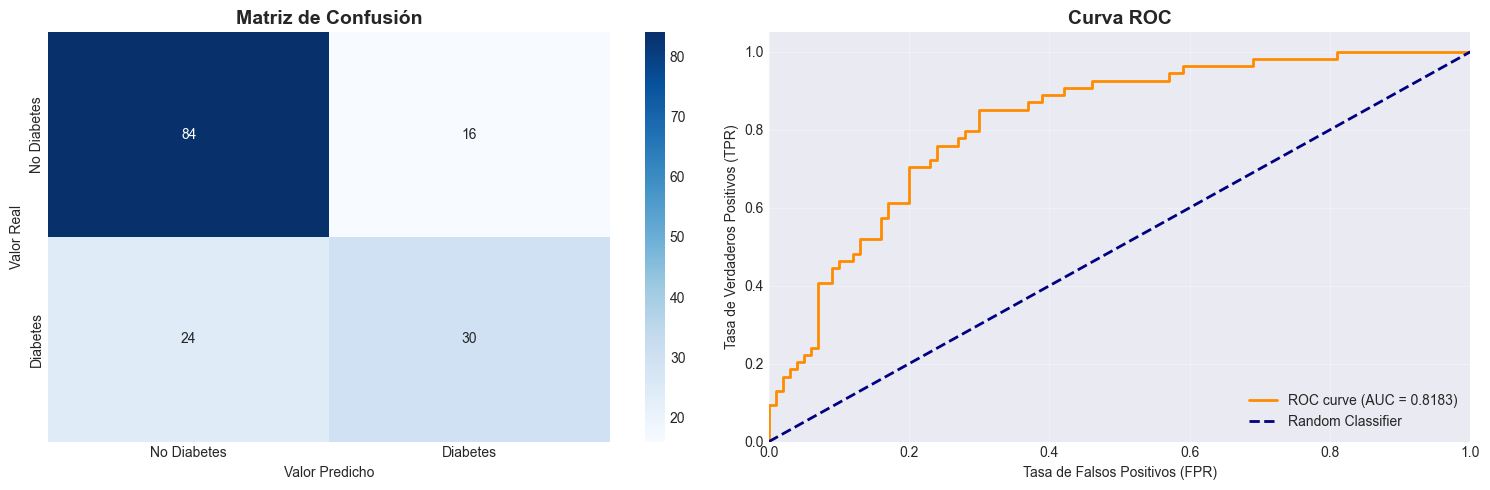

In [15]:
# VISUALIZACIONES FINALES
# =======================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[0].set_title('Matriz de Confusión', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Valor Predicho')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


IMPORTANCIA DE CARACTERÍSTICAS
Feature  Importance
   plas    0.320649
   mass    0.161569
    age    0.127625
   test    0.100126
   preg    0.087106
   pedi    0.083209
   skin    0.072016
   pres    0.047700


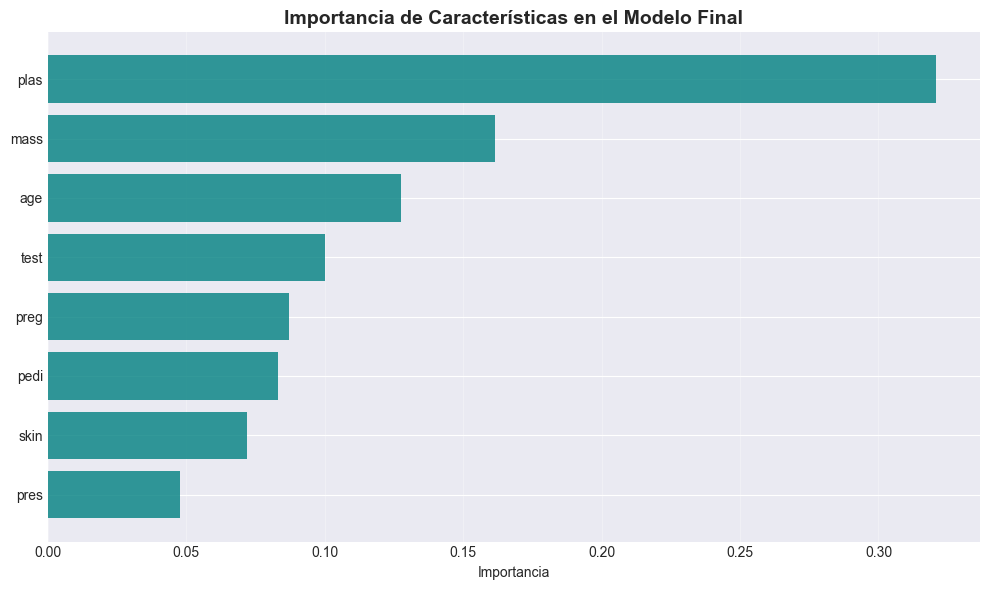

In [16]:
# IMPORTANCIA DE CARACTERÍSTICAS
# ===============================

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "=" * 80)
    print("IMPORTANCIA DE CARACTERÍSTICAS")
    print("=" * 80)
    print(feature_importance.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='teal', alpha=0.8)
    plt.xlabel('Importancia')
    plt.title('Importancia de Características en el Modelo Final', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [17]:
# RESUMEN FINAL
# =============

print("\n" + "=" * 80)
print("RESUMEN DE LA PRÁCTICA")
print("=" * 80)

print(f"""
MODELOS EVALUADOS:
------------------
1. Bagging Classifier (Bagging)
2. Random Forest (Bagging)
3. AdaBoost (Boosting)
4. Gradient Boosting (Boosting)
5. XGBoost (Boosting)

MODELO SELECCIONADO: XGBoost Classifier
---------------------------------------
Justificación:
- Mejor ROC-AUC en validación cruzada
- Robusto ante datos desbalanceados
- Manejo eficiente de características
- Regularización incorporada

HIPERPARÁMETROS OPTIMIZADOS:
{grid_search.best_params_}

RENDIMIENTO FINAL EN TEST:
--------------------------
Accuracy:  {accuracy:.4f}
Precision: {precision:.4f}
Recall:    {recall:.4f}
F1-Score:  {f1:.4f}
ROC-AUC:   {roc_auc:.4f}

CONCLUSIONES:
-------------
El modelo final muestra un buen rendimiento en la predicción de diabetes,
con un ROC-AUC de {roc_auc:.4f}, lo que indica una capacidad sólida para
discriminar entre pacientes que desarrollarán diabetes y las que no.

Las características más importantes son la concentración de glucosa en plasma,
el índice de masa corporal y la edad, lo cual es consistente con el conocimiento
médico sobre factores de riesgo de diabetes.
""")

print("=" * 80)
print("FIN DE LA PRÁCTICA")
print("=" * 80)


RESUMEN DE LA PRÁCTICA

MODELOS EVALUADOS:
------------------
1. Bagging Classifier (Bagging)
2. Random Forest (Bagging)
3. AdaBoost (Boosting)
4. Gradient Boosting (Boosting)
5. XGBoost (Boosting)

MODELO SELECCIONADO: XGBoost Classifier
---------------------------------------
Justificación:
- Mejor ROC-AUC en validación cruzada
- Robusto ante datos desbalanceados
- Manejo eficiente de características
- Regularización incorporada

HIPERPARÁMETROS OPTIMIZADOS:
{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

RENDIMIENTO FINAL EN TEST:
--------------------------
Accuracy:  0.7403
Precision: 0.6522
Recall:    0.5556
F1-Score:  0.6000
ROC-AUC:   0.8183

CONCLUSIONES:
-------------
El modelo final muestra un buen rendimiento en la predicción de diabetes,
con un ROC-AUC de 0.8183, lo que indica una capacidad sólida para
discriminar entre pacientes que desarrollarán diabetes y las que no.

Las características más importantes son la con